In [2]:
# import libraries
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# model summary info
from torchsummary import summary

import matplotlib.pyplot as plt

from typing import Tuple, Sequence, Optional, List

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Create Gaussian blurs with varying widths and occluding bars

In [4]:
nGauss  = 1000
imgSize = 91

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
imagesNonOcc = torch.zeros(nGauss,1,imgSize,imgSize)
imagesOcc = torch.zeros(nGauss,1,imgSize,imgSize)


for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor to create non-occluded images
  imagesNonOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor to create occluded images
  imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

img_sizes = (imagesOcc.shape[2],imagesOcc.shape[3])

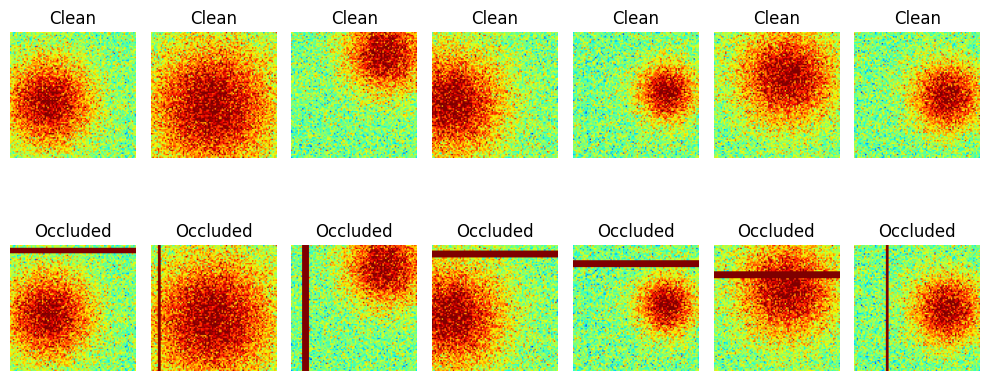

In [5]:
# visualize some images
fig,axs = plt.subplots(2,7,figsize=(10,5))

idx = np.random.randint(nGauss,size=7)

# Plot clean/ non-Occluded images
for i in range(7):
  axs[0,i].imshow(imagesNonOcc[idx[i],0,:,:], vmin=-1, vmax=1, cmap='jet')
  axs[0,i].set_title('Clean')
  axs[0,i].axis('off')

# Plot occluded images
for i in range(7):
  axs[1,i].imshow(imagesOcc[idx[i],0,:,:], vmin=-1, vmax=1, cmap='jet')
  axs[1,i].set_title('Occluded')
  axs[1,i].axis('off')

plt.tight_layout()
plt.show();

# Create the DL model

In [6]:
# ---- building blocks ----
class ConvBlock(nn.Module):
    def __init__(self, in_c: int, out_c: int, use_bn: bool = False):
        super().__init__()
        layers = [
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_bn: layers.append(nn.BatchNorm2d(out_c))
        layers += [
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        ]
        if use_bn: layers.append(nn.BatchNorm2d(out_c))
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

class Down(nn.Module):
    def __init__(self, in_c: int, out_c: int, use_bn: bool = False):
        super().__init__()
        self.block = ConvBlock(in_c, out_c, use_bn)
        self.pool  = nn.MaxPool2d(2)

    def forward(self, x):
        feat = self.block(x)
        return feat, self.pool(feat)   # return skip + pooled

class Up(nn.Module):
    def __init__(self, in_c: int, skip_c: int, out_c: int, use_bn: bool = False):
        super().__init__()
        self.ups   = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=False)
        self.conv1 = nn.Conv2d(in_c, out_c, 3, padding=1)
        self.block = ConvBlock(out_c + skip_c, out_c, use_bn)

    def forward(self, x, skip):
        x = self.ups(x)
        # crop skip if size mismatch (odd dimensions)
        if x.shape[-2:] != skip.shape[-2:]:
            dh = skip.shape[-2] - x.shape[-2]
            dw = skip.shape[-1] - x.shape[-1]
            skip = skip[..., dh//2:skip.shape[-2]-(dh-dh//2),
                          dw//2:skip.shape[-1]-(dw-dw//2)]
        x = F.relu(self.conv1(x))
        x = torch.cat([x, skip], dim=1)
        return self.block(x)

# ---- model factory ----
def makeTheNet(
    in_channels: int = 1,
    enc_channels: Sequence[int] = (16,32,64),
    bottleneck_channels: int = 128,
    final_activation: str = "sigmoid",
    use_bn: bool = False,
    lr: float = 1e-3,
):
    class UNetAE(nn.Module):
        def __init__(self):
            super().__init__()
            # encoder
            self.down1 = Down(in_channels, enc_channels[0], use_bn)
            self.down2 = Down(enc_channels[0], enc_channels[1], use_bn)
            self.down3 = Down(enc_channels[1], enc_channels[2], use_bn)
            # bottleneck
            self.latent = ConvBlock(enc_channels[2], bottleneck_channels, use_bn)
            # decoder
            self.up3 = Up(bottleneck_channels, enc_channels[2], enc_channels[2], use_bn)
            self.up2 = Up(enc_channels[2], enc_channels[1], enc_channels[1], use_bn)
            self.up1 = Up(enc_channels[1], enc_channels[0], enc_channels[0], use_bn)
            self.out_conv = nn.Conv2d(enc_channels[0], in_channels, kernel_size=1)

            act = final_activation.lower()
            if act == "sigmoid":   self.final = nn.Sigmoid()
            elif act == "tanh":    self.final = nn.Tanh()
            else:                  self.final = nn.Identity()

        def forward(self, x):
            s1, x = self.down1(x)   # skip1, pooled
            s2, x = self.down2(x)   # skip2, pooled
            s3, x = self.down3(x)   # skip3, pooled
            x = self.latent(x)
            x = self.up3(x, s3)
            x = self.up2(x, s2)
            x = self.up1(x, s1)
            x = self.out_conv(x)
            # force exact match with input HxW
            x = F.interpolate(x, size=(s1.shape[-2], s1.shape[-1]),
                              mode="bilinear", align_corners=False)
            return self.final(x)

        def get_latent(self, x):
            _, x = self.down1(x)
            _, x = self.down2(x)
            _, x = self.down3(x)
            return self.latent(x)

    net = UNetAE()
    lossfun = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    return net, lossfun, optimizer

# ---- quick test ----
if __name__ == "__main__":
    net, lossfun, opt = makeTheNet()
    for size in [91, 47, 64]:
        X = torch.randn(2,1,size,size)  # batch=2
        Y = net(X)
        print(f"in={X.shape} -> out={Y.shape}")


in=torch.Size([2, 1, 91, 91]) -> out=torch.Size([2, 1, 91, 91])
in=torch.Size([2, 1, 47, 47]) -> out=torch.Size([2, 1, 47, 47])
in=torch.Size([2, 1, 64, 64]) -> out=torch.Size([2, 1, 64, 64])


# Create a function that trains the model

In [7]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 500

  # create a new model
  net,lossfun,optimizer = makeTheNet()
  net = net.to(device)

  # initialize losses
  losses = torch.zeros(numepochs)

  # loop over epochs
  for epochi in range(numepochs):

    # pick a set of images at random
    pics2use = np.random.choice(nGauss,size=32,replace=False)
    X = imagesOcc[pics2use,:,:,:]
    y = imagesNonOcc[pics2use,:,:,:]

    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = net(X)

    yHat = yHat.cpu()
    y = y.cpu()

    loss = lossfun(yHat,y)
    losses[epochi] = loss.item()

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  # end epochs

  # function output
  return losses,net

# Run the model and show the results!

In [8]:
# train the model
losses,net = function2trainTheModel()

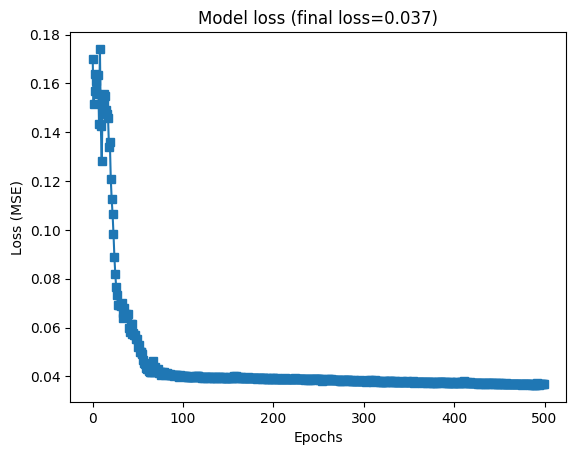

In [9]:
# Visualize the losses
plt.plot(losses.detach(),'s-',label='Train') # Use detach() as losses is a tensor
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Model loss (final loss=%.3f)'%losses[-1])

plt.show();

# Visualize the Results

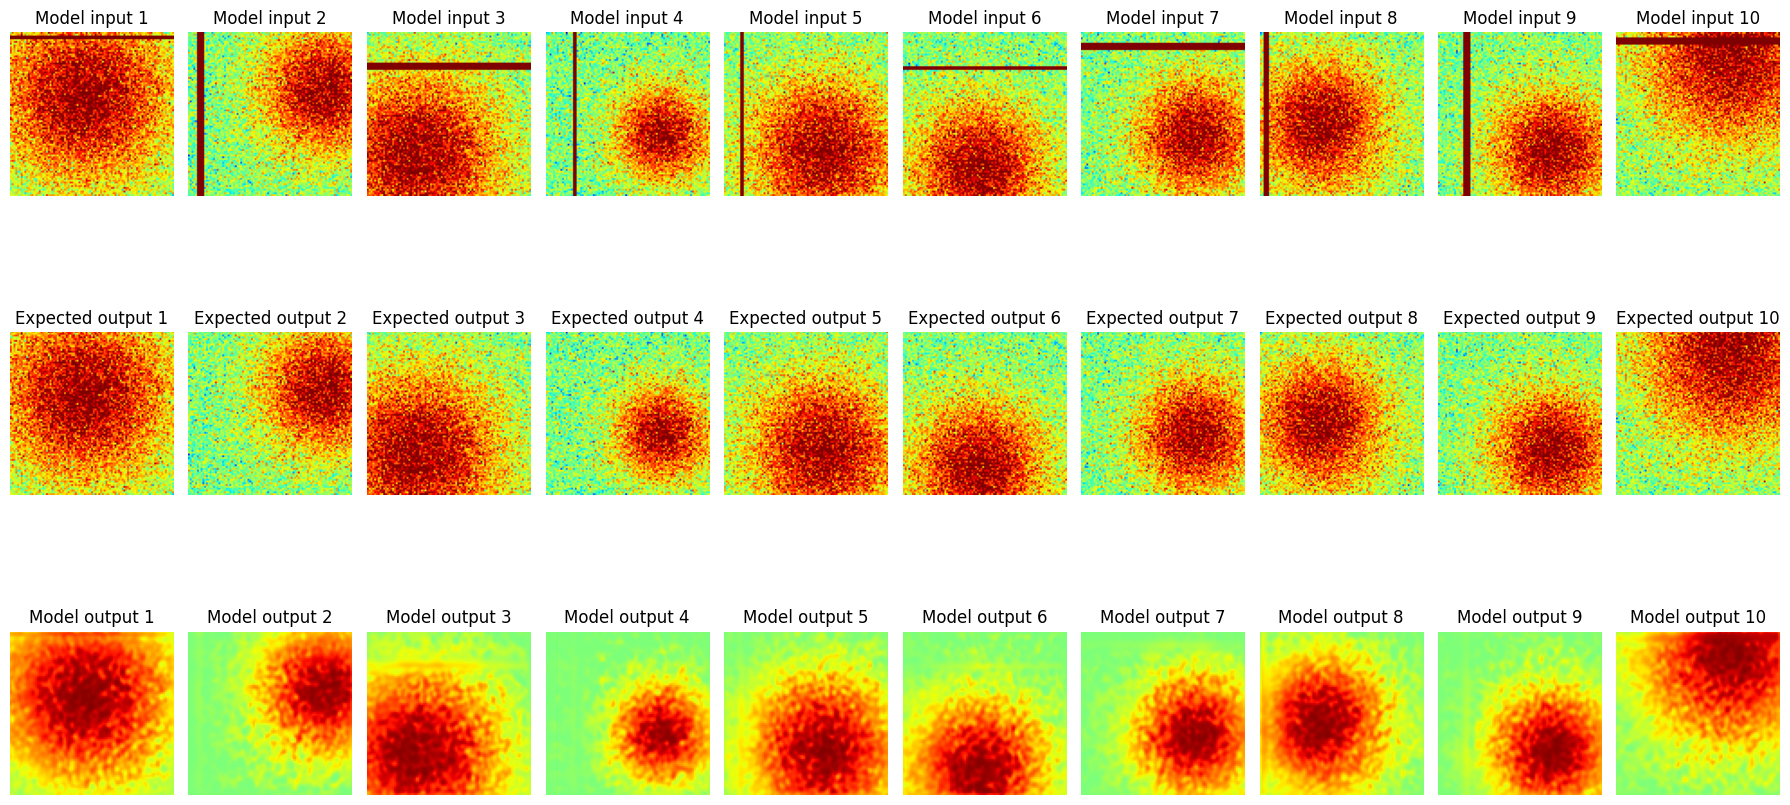

In [10]:
# visualize some images

pics2use = np.random.choice(nGauss,size=32,replace=False)
X = imagesOcc[pics2use,:,:,:]
y = imagesNonOcc[pics2use,:,:,:]

X = X.to(device)
y = y.to(device)

yHat = net(X)

yHat = yHat.cpu()
y = y.cpu()
X = X.cpu()

fig,axs = plt.subplots(3,10,figsize=(18,10))

for i in range(10):

  model_input = torch.squeeze( X[i,0,:,:] ).detach()
  model_labels = torch.squeeze( y[i,0,:,:] ).detach()
  model_output = torch.squeeze( yHat[i,0,:,:] ).detach()

  axs[0,i].imshow(model_input,vmin=-1,vmax=1,cmap='jet')
  axs[0,i].axis('off')
  axs[0,i].set_title(f'Model input {i+1}')

  axs[1,i].imshow(model_labels,vmin=-1,vmax=1,cmap='jet')
  axs[1,i].axis('off')
  axs[1,i].set_title(f'Expected output {i+1}')

  axs[2,i].imshow(model_output,vmin=-1,vmax=1,cmap='jet')
  axs[2,i].axis('off')
  axs[2,i].set_title(f'Model output {i+1}')

plt.tight_layout()

plt.show();

# Save the model

In [11]:
torch.save(net.state_dict(),'/content/drive/MyDrive/Colab Notebooks/DeOclusionModel.ipynb')

# Test the model

In [ ]:
# Generate test data
nGauss  = 1000
imgSize = 53

x = np.linspace(-4,4,imgSize)
X,Y = np.meshgrid(x,x)

# vary the weights smoothly
widths = np.linspace(2,20,nGauss)

# initialize tensor containing images
imagesNonOcc = torch.zeros(nGauss,1,imgSize,imgSize)
imagesOcc = torch.zeros(nGauss,1,imgSize,imgSize)


for i in range(nGauss):

  # create the gaussian with random centers
  ro = 1.5*np.random.randn(2) # ro = random offset
  G  = np.exp( -( (X-ro[0])**2 + (Y-ro[1])**2) / widths[i] )

  # and add noise
  G = G + np.random.randn(imgSize,imgSize)/5

  # add to the tensor to create non-occluded images
  imagesNonOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

  # add a random bar randomly
  i1 = np.random.choice(np.arange(2,28))
  i2 = np.random.choice(np.arange(2,6))
  if np.random.randn()>0:
    G[i1:i1+i2,] = 1
  else:
    G[:,i1:i1+i2] = 1

  # add to the tensor to create occluded images
  imagesOcc[i,:,:,:] = torch.Tensor(G).view(1,imgSize,imgSize)

# Load the model back for testing

In [12]:
net2,lossfun2,opt2 = makeTheNet()
net2.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/DeOclusionModel.ipynb'))
net2 = net2.to(device)

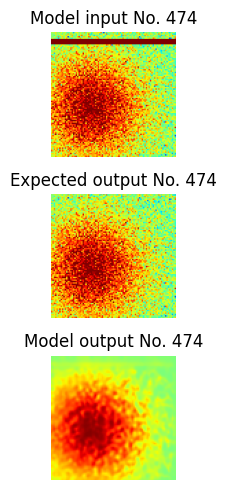

In [13]:
net2.eval()

idx = np.random.randint(nGauss)
X = imagesOcc[idx,:,:,:]
y = imagesNonOcc[idx,:,:,:]

X = X.to(device)
y = y.to(device)

# Ensure X has the correct shape [1, 1, imgSize, imgSize]
if X.dim() == 3:
    X = X.unsqueeze(0)
elif X.dim() == 4 and X.size(0) != 1:
    # This case should not happen with the current indexing, but as a safeguard
    print(f"Warning: Unexpected batch size in test input: {X.size(0)}. Proceeding with the first image.")
    X = X[0].unsqueeze(0)
elif X.dim() != 4 or X.size(1) != 1 or X.size(2) != imgSize or X.size(3) != imgSize:
     print(f"Error: Test input X has unexpected shape: {X.shape}")


yHat = net2(X)

yHat = yHat.cpu()
y = y.cpu()
X = X.cpu()

fig,axs = plt.subplots(3,1,figsize=(10,5))
axs[0].imshow(X[0,0,:,:],vmin=-1,vmax=1,cmap='jet') # X should have batch and channel dimensions
axs[0].axis('off')
axs[0].set_title(f'Model input No. {idx}')

axs[1].imshow(y[0,:,:],vmin=-1,vmax=1,cmap='jet') # Corrected indexing for y
axs[1].axis('off')
axs[1].set_title(f'Expected output No. {idx}')

axs[2].imshow(yHat[0,0,:,:].data,vmin=-1,vmax=1,cmap='jet') # yHat should have batch and channel dimensions
axs[2].axis('off')
axs[2].set_title(f'Model output No. {idx}')
plt.tight_layout()
plt.show()